In [1]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import networkx as nx

import scipy.stats as st

# Common test variables
Run python script with variables common to all synthetic experiments, also sets random seed.

In [2]:
%run -i "test_variables.py"

# Addition of nodes with unique opinions

In [3]:
experiment_folder = 'add_orthog_nodes/'

### Local Setup

Figure saved.


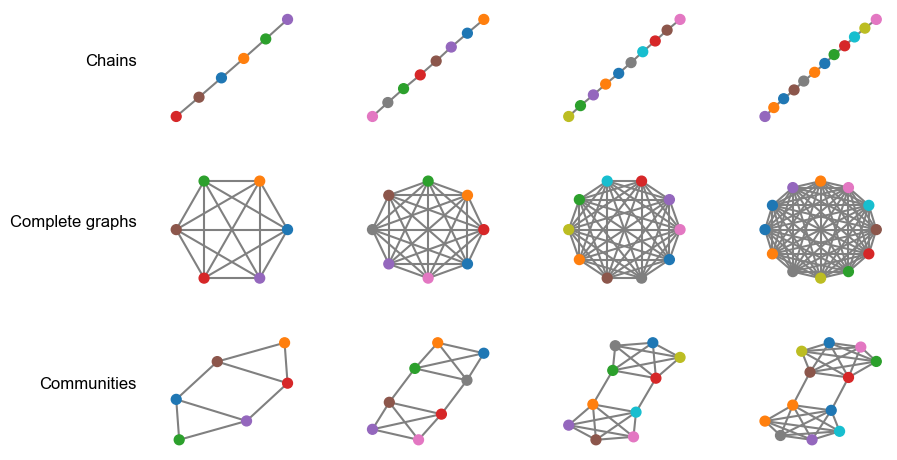

In [4]:
fig, ax = plt.subplots(3, len(local_num_nodes_range), figsize=(2*len(local_num_nodes_range), 5))
fig.tight_layout()


for test_index, (name, graph_gen) in enumerate(local_tests):
    ax[test_index, 0].set_ylabel(name, rotation=0, labelpad=20, fontsize=12, ha='right')
 
    for num_nodes_index, num_nodes in enumerate(local_num_nodes_range):

        if name == 'Communities':
            G = graph_gen(2, num_nodes//2)
        else:
            G = graph_gen(num_nodes)
        
        pos = nx.kamada_kawai_layout(G) # seed=1, k=10, iterations=1000

        # hide subplot axes lines
        for direction in ['top','right','left','bottom']:
            ax[test_index, num_nodes_index].spines[direction].set_visible(False)

        cmap = utils.qualitative_cmap(num_nodes)

        nx.draw_networkx_nodes(G, ax=ax[test_index, num_nodes_index], pos=pos, node_size=node_size, cmap=cmap, node_color=range(num_nodes))
        nx.draw_networkx_edges(G, ax=ax[test_index, num_nodes_index], edge_color='gray', pos=pos, width=local_edge_width)
# nx.draw(G, ax=ax[test_index, num_nodes_index], with_labels=False, node_size=25, edge_color='dimgray', node_color=name_color[name])

utils.save_figure("local_setup", experiment_folder, overwrite=True)

### Local Results

D:\OneDrive\ITU\Bachelor's Project\Quantifying-Multipolar-Polarization\tests\methods\torch_nvd.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  diff_T = diff.T


Figure saved.


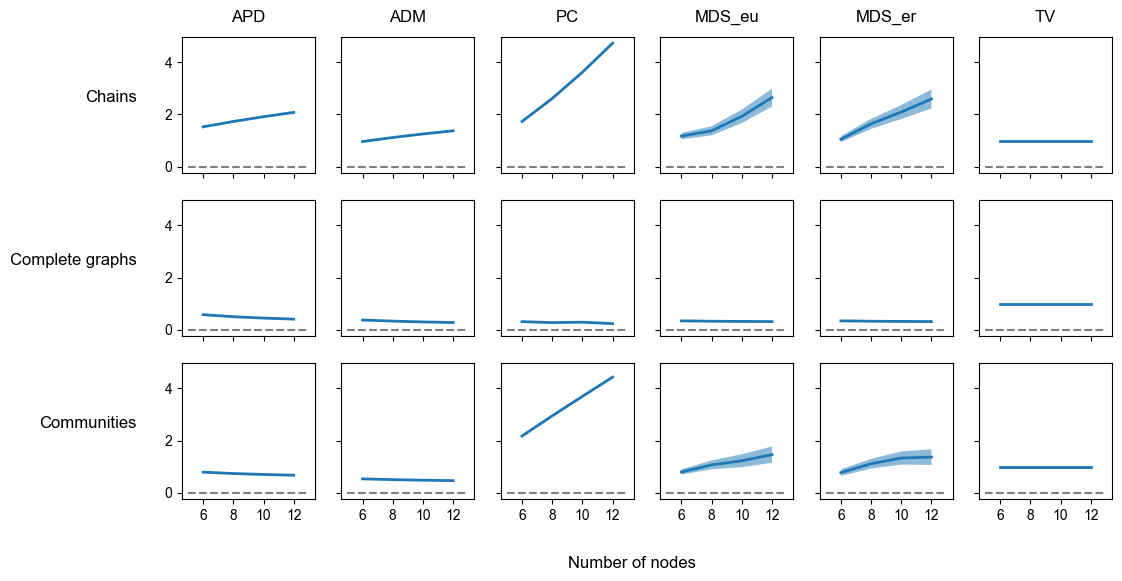

In [7]:
num_nodes_range = [6,8,10,12]

fig, ax = plt.subplots(len(local_tests), len(metrics), figsize=(len(metrics)*2, len(local_tests)*2), sharey=True, sharex=True)

# Set ticks for all x axes (since they are shared)
ax[0, 0].set_xticks(num_nodes_range)

for test_index, (graph_name, graph_type) in enumerate(local_tests):

    for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

        # Initialize arrays to store the means and confidence intervals of repeated runs
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_opinions in enumerate(num_nodes_range):

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=2, nodes_per_comm=num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions*2)], data=np.identity(num_opinions*2))
                else:
                    G = graph_type(num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))

                
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)
                run_pols[run] = polarization

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[test_index, metric_index].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[test_index, metric_index].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[test_index, metric_index].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed', label='Expected')

        # Add title to the first row
        if test_index == 0:
            ax[test_index, metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

        # Add title to the first column
        if metric_index == 0:
            ax[test_index, metric_index].set_ylabel(graph_name, rotation=0, labelpad=20, fontsize=12, ha='right')


# fig.suptitle(graph_name, y=1.2, fontsize=16)

# fig.supylabel('Polarization', x=0.08)
fig.supxlabel('Number of nodes', fontsize=12, y=-0.01)

utils.save_figure("local_res", experiment_folder, overwrite=True)

### Global Setup

In [8]:
p_in = 0.1
p_out = 0.01
n_comms = 3
intercon = 2
nodes_per_comm = 100

In [9]:
def generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out):
    
    G2 = utils.stochastic_block_model(n_comms, nodes_per_comm, p_in, p_out)

    # Make G1 = G2 and remove last nodes_per_comm nodes from G1
    G1 = G2.copy()
    G1.remove_nodes_from(list(G1.nodes)[-nodes_per_comm:])
    return G1, G2

Figure saved.


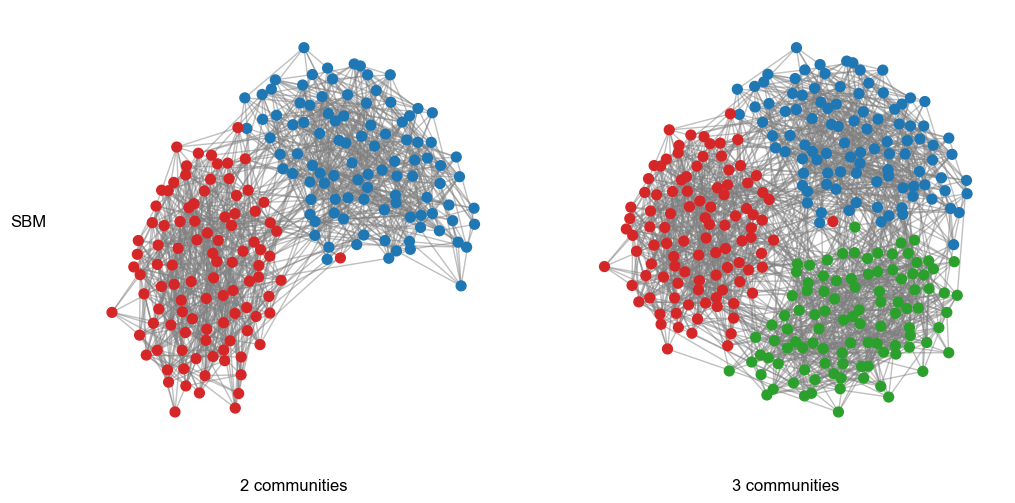

In [10]:
G1, G2 = generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out)

# Make G1 have nodes in the same position as G2
G2_pos = nx.kamada_kawai_layout(G2)
G1_pos = {node: G2_pos[node] for node in G1.nodes}

cmap = bgr_cmap()

fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))
for direction in ['top','right','left','bottom']:
    for axis in ax:
        axis.spines[direction].set_visible(False)
fig.tight_layout()

ax[0].set_ylabel("SBM", rotation=0, labelpad=20, fontsize=12, ha='right')

nx.draw_networkx_nodes(G1, ax=ax[0], pos=G1_pos, node_size=node_size, cmap=cmap, node_color=[0]*nodes_per_comm + [2]*nodes_per_comm)
nx.draw_networkx_edges(G1, ax=ax[0], edge_color='gray', pos=G1_pos, width=global_edge_width, alpha=global_edge_alpha)
ax[0].set_xlabel("2 communities", fontsize=12, labelpad=20)

nx.draw_networkx_nodes(G2, ax=ax[1], pos=G2_pos, node_size=node_size, cmap=cmap, node_color=[0]*nodes_per_comm + [2]*nodes_per_comm + [1]*nodes_per_comm)
nx.draw_networkx_edges(G2, ax=ax[1], edge_color='gray', pos=G2_pos, width=global_edge_width, alpha=global_edge_alpha)
ax[1].set_xlabel("3 communities", fontsize=12, labelpad=20)


utils.save_figure("global_setup", experiment_folder, overwrite=True)

### Global Results

Figure saved.


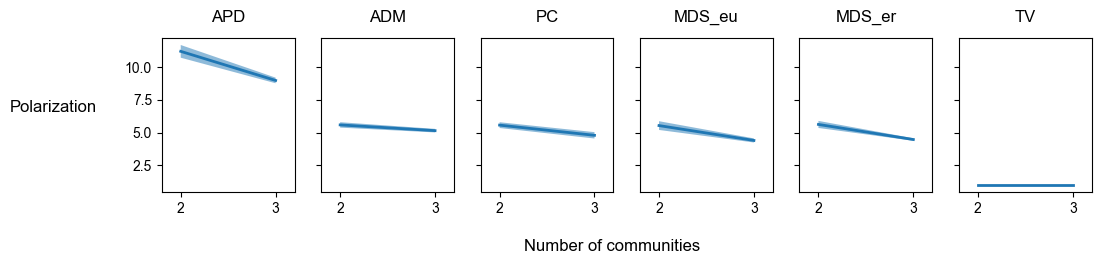

In [50]:
x_range = [2,3]

fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics)*2, 2), sharey=True, sharex=True)

# Set ticks for all x axes (since they are shared)
ax[0].set_xticks(x_range)

# Set x limits
ax[0].set_xlim(x_range[0]-0.2, x_range[-1]+0.2)

for metric_index, (metric_name, polarization_metric) in enumerate(metrics):
    G1_run_pols = np.zeros(num_runs)
    G2_run_pols = np.zeros(num_runs)
    
    for run in range(num_runs):

        G1, G2 = generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out)

        o = pd.DataFrame(columns=['o'+str(i) for i in range(2)], data=np.array([[1,0]]*nodes_per_comm + [[0,1]]*nodes_per_comm))
        tensor = nvd.make_tensor(G1, o)
        polarization = polarization_metric(tensor)
        G1_run_pols[run] = polarization

        o = pd.DataFrame(columns=['o'+str(i) for i in range(3)], data=np.array([[1,0,0]]*nodes_per_comm + [[0,1,0]]*nodes_per_comm + [[0,0,1]]*nodes_per_comm))
        tensor = nvd.make_tensor(G2, o)
        polarization = polarization_metric(tensor)
        G2_run_pols[run] = polarization

    G1_mean = np.mean(G1_run_pols)
    G2_mean = np.mean(G2_run_pols)

    # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
    G1_run_pols += np.random.normal(0, 1e-10, len(G1_run_pols))
    G2_run_pols += np.random.normal(0, 1e-10, len(G2_run_pols))

    # Calculate the 95% confidence intervals
    G1_lower_conf, G1_higher_conf = st.t.interval(0.95, len(G1_run_pols)-1, loc=G1_mean, scale=st.sem(G1_run_pols))
    G2_lower_conf, G2_higher_conf = st.t.interval(0.95, len(G2_run_pols)-1, loc=G2_mean, scale=st.sem(G2_run_pols))

    ax[metric_index].plot(x_range, [G1_mean, G2_mean], lw=2)
    ax[metric_index].fill_between(x_range, [G1_higher_conf, G2_higher_conf], [G1_lower_conf, G2_lower_conf], alpha=.5, linewidth=0, label='95% CI')
    # ax[metric_index].hlines(0, x_range[0], xmax=x_range[-1], colors='gray', linestyles='dashed', label='Expected')

    # Add title
    ax[metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

    # Add title to the first column
    if metric_index == 0:
        ax[metric_index].set_ylabel("Polarization", rotation=0, labelpad=20, fontsize=12, ha='right')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

#fig.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=1, fontsize=12, bbox_to_anchor=(0.8, -0.4), frameon=False)

fig.supxlabel('Number of communities', fontsize=12, y=-0.2)

utils.save_figure("global_res", experiment_folder, overwrite=True)

# Interpreting neutral nodes as new opinion

In [51]:
experiment_folder = 'neutral_to_orthog_opinion/'

### Local Setup

### Local Results

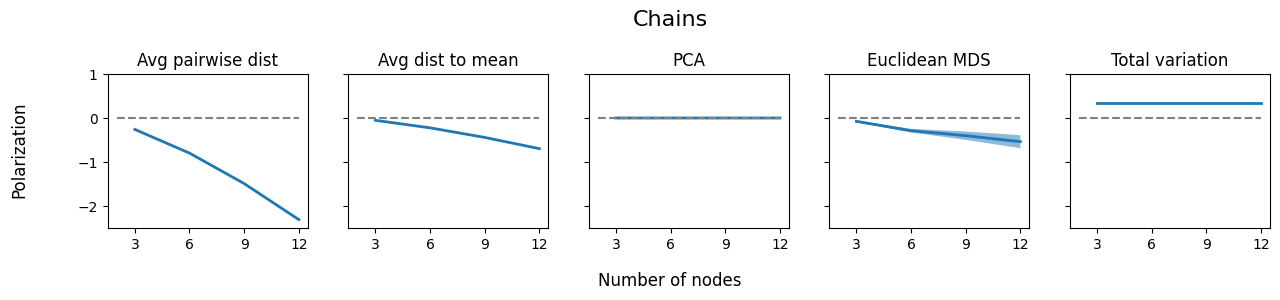

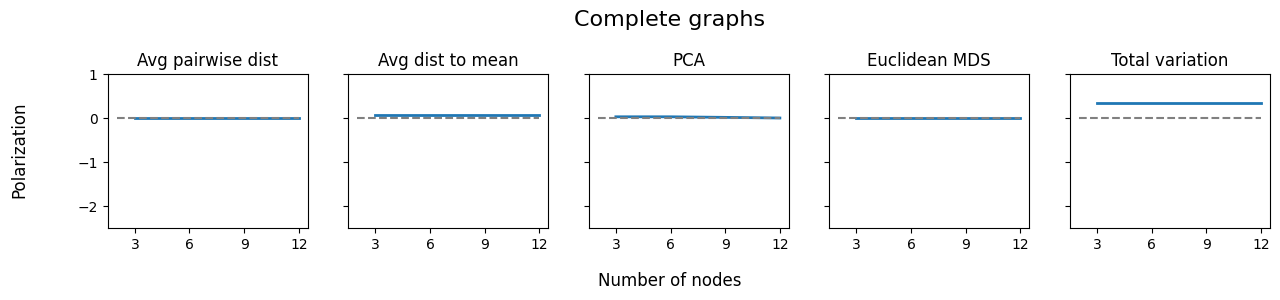

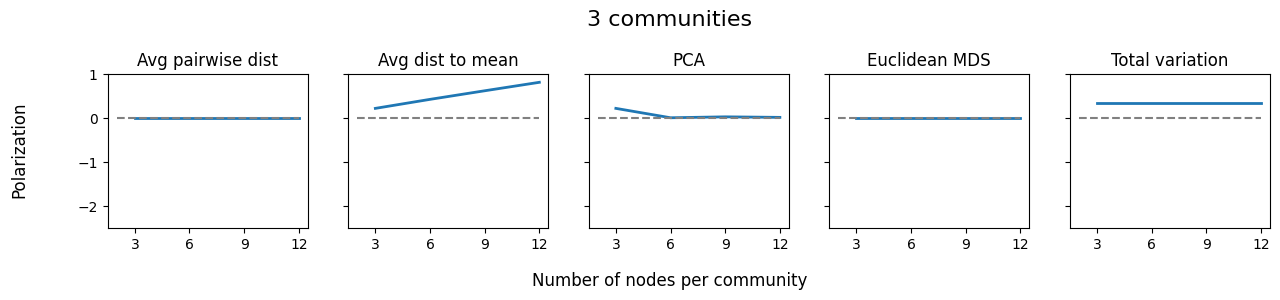

In [4]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                # neutral opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                                    np.array([(0,0)]*nodes_per_comm),
                                                                    np.array([(0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                neutral_polarization = polarization_metric(tensor)

                # third opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                            np.array([(0,1,0)]*nodes_per_comm),
                                                                            np.array([(0,0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                third_polarization = polarization_metric(tensor)

                difference = third_polarization - neutral_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-2.5, 1)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

### Global Setup

### Global Results

# Duplicating one or more opinion vectors

Note: for some reason it makes no difference whether I duplicate one or 3 opinions, is it a bug?

### Duplicating all 3 orthogonal opinions

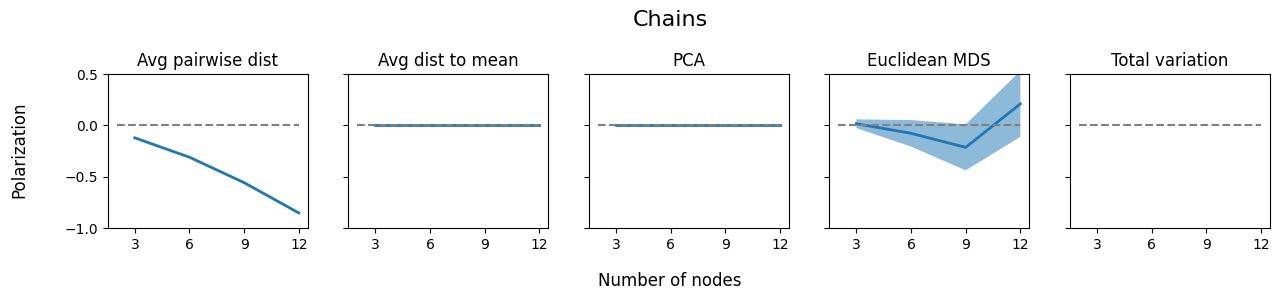

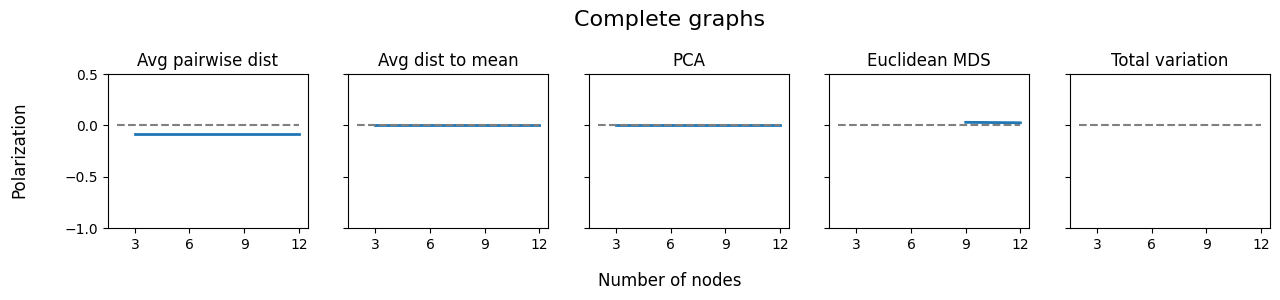

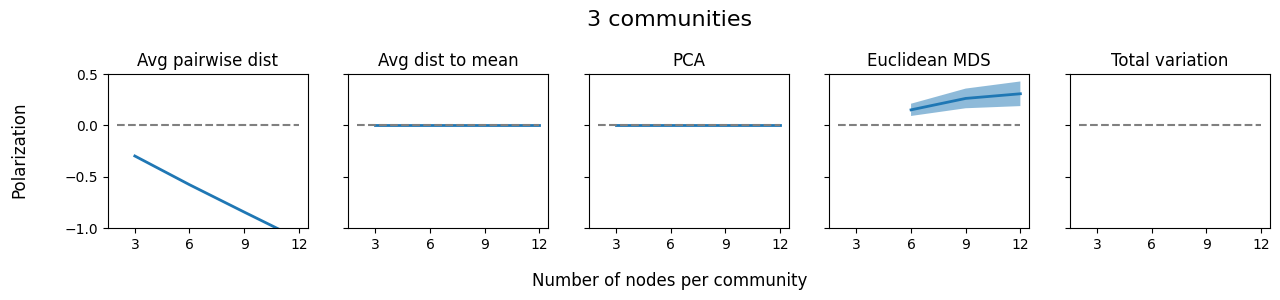

In [8]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 40

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate o
                dup_o = pd.concat([o, o], axis=1)
                # rename columns
                dup_o.columns = ['o'+str(i) for i in range(len(dup_o.columns))]

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-1, 0.5)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

### Duplicating 1 of 3 orthogonal opinions

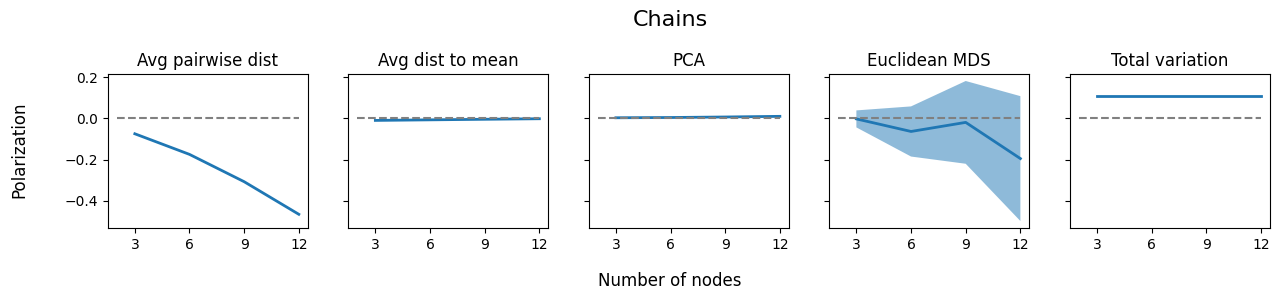

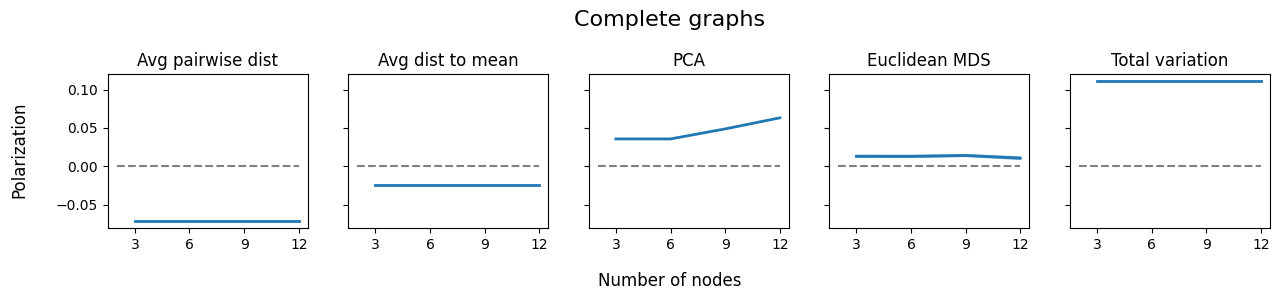

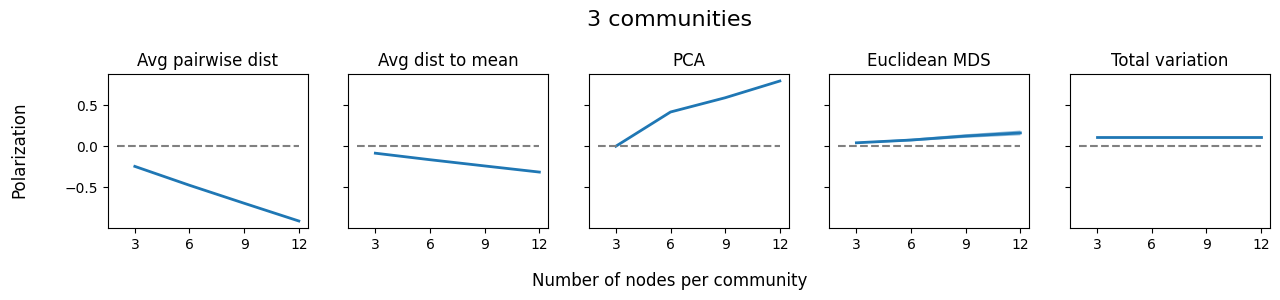

In [6]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_name == '3 communities':
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate last column of o
                dup_o = pd.concat([o, o.iloc[:, -1]], axis=1)

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)

    if graph_name == '3 communities':
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

In [7]:
def plot_test(num_opinions_range, n_nodes, n_comms, p_out, intercon, polarization_metrics, metric_names, plot_title, plot_xlabel, plot_ylabel, opinion_type, num_runs=10):
    """
    Plot the polarization of a SBM graph with different number of opinions and different polarization metrics.
    
    num_opinions_range: range, range of number of opinions to test
    num_runs: int, number of runs random initializations for each test
    opinion_types: list, list of opinion types to test
    """

    if not n_nodes % n_comms == 0:
        raise ValueError(f'n_nodes={n_nodes} not divisible by n_comms={n_comms}')
    nodes_per_comm = n_nodes//n_comms

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        pols = np.array([])
        pol_lower_conf = np.array([])
        pol_higher_conf = np.array([])

        for num_opinions in num_opinions_range:

            run_pols = np.zeros(num_runs)

            for run in range(num_runs):

                G = SBM_graph(n_nodes, n_comms, p_out, intercon, nodes_per_comm)
    

                if opinion_type == 'unique':
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
                elif opinion_type == 'orthogonal':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                                np.array([(0,1,0)]*nodes_per_comm),
                                                                                np.array([(0,0,1)]*nodes_per_comm))))
                elif opinion_type == 'correlated':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                                np.array([(0,1,1)]*nodes_per_comm),
                                                                                np.array([(1,0,1)]*nodes_per_comm))))
                else:
                    raise ValueError(f'opinion_type={opinion_type} not valid. Must be one of "unique", "orthogonal", "correlated".')

                tensor = nvd.make_tensor(G, o)
                Linv = nvd._Linv(tensor)

                polarization = polarization_metric(tensor, Linv=Linv)
                run_pols[run] = polarization

            # Calculate the mean polarization of num_runs runs
            pols = np.append(pols, np.mean(run_pols))  

            # Calculate the 95% confidence intervals of the mean polarization
            lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
            pol_lower_conf = np.append(pol_lower_conf, lower_conf)
            pol_higher_conf = np.append(pol_higher_conf, higher_conf)

        ax[i].plot(num_opinions_range, pols, lw=2)
        ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)  # Shade the 95% confidence interval around the mean
        ax[i].set_title(metric_name)

    fig.suptitle(plot_title, y=1.1, fontsize=16)
    fig.supxlabel(plot_xlabel, y=-0.1)
    fig.supylabel(plot_ylabel, x=0.05);